### Word Cloud 만들기

```markdown
* 팀 활동 요구사항
제공된 데이터셋과 유사한 데이터셋을 웹 스크레이핑을 통해 만든 다음, word cloud를 만들어 봅시다.
데이터셋을 만들 때 어떤 작업들이 추가적으로 필요할까요?
prototyping에는 최소 1,000개 이상의 데이터를 사용하세요.
해당 분석을 통해 어떤 비즈니스 가치를 만들 수 있을지에 대해 토의합시다.
```

### 절차
<aside>
💡1. 웹 스크래핑을 통한 데이터 추출 → CSV 형태로 저장 (Extract → Load)<br>
💡2. CSV 파일을 읽어 전처리 하여 Word Cloud 생성 (Transform, Analyze)
</aside>

### 프로토타이핑
- 사용할 데이터 셋 : 네이버 웹툰 댓글
- 데이터셋을 만들 때 필요한 작업 : Sentiment 수준에 대한 정보를 함께 다뤄야 합니다.
    - 댓글의 공감/비공감 수치를 통해 감정 분석을 진행함 여러가지 방법이 있을 수 있음


```markdown
[방법1] 채택
(공감 - 비공감) > 0 인 경우 긍정으로 분류
(공감 - 비공감) < 0 인 경우 부정으로 분류
이외에는 중립

[방법2]
(공감 - 비공감) > 0 인 경우 긍정으로 분류, |공감 - 비공감| 만큼 가중치
(공감 - 비공감) < 0 인 경우 부정으로 분류, |공감 - 비공감| 만큼 가중치
이외에는 중립

방법 1을 사용하여 데이터 분석 과정을 거치고 확인합니다.
```

In [170]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.common.by import By
from konlpy.tag import Okt
from collections import Counter
import time
import re

## 데이터 크롤링

In [171]:
# df = pd.DataFrame(columns=['text', 'pos', 'neg', 'distance'])
# df.to_csv("webtoon_data.csv", index=False)

In [172]:
"""
path는 해당 웹툰의 링크를 넣으면 됩니다.
이 함수는 댓글이 있는 하나의 화에 해당하는 내용입니다.
이 함수를 호출하는 상위 레이어에서 여러 웹툰, 여러 회차에 대해서 데이터들을 수집하기 위해 사용할 수 있습니다.
"""
def crawl_comment_from_webtoon(path : str):
    data = []
    
    driver = webdriver.Chrome()
    driver.get(path)
    time.sleep(0.1)
    
    clean_bot_option = driver.find_element(By.CLASS_NAME, "u_cbox_cleanbot_setbutton")
    clean_bot_option.click()
    time.sleep(0.1)
    
    clean_bot_off = driver.find_element(By.ID, "cleanbot_dialog_checkbox_cbox_module")
    clean_bot_off.click()
    time.sleep(0.1)
    
    clean_bot_admit_button = driver.find_element(By.CLASS_NAME, "u_cbox_layer_cleanbot2_extrabtn")
    clean_bot_admit_button.click()
    time.sleep(0.1)
    
    sort_all_comment = driver.find_element(By.ID, "cbox_module_wai_u_cbox_sort_option_tab2")
    sort_all_comment.click()
    time.sleep(0.1)
    
    cbox_btn_more = driver.find_element(By.CLASS_NAME, "u_cbox_btn_more")
    
    # try exception으로 댓글이 더이상 없을 때까지 댓글을 불러옵니다.
    cnt = 0
    try:
        while True:
            cbox_btn_more.click()
            cnt += 1
            time.sleep(0.5)
        
    except:
        pass
        
        
    comment_list_container = driver.find_element(By.CLASS_NAME, "u_cbox_list")
    comment_list = comment_list_container.find_elements(By.TAG_NAME, "li")
    for li in comment_list:
        deleted = []
        deleted = li.find_elements(By.CLASS_NAME, "u_cbox_type_delete")
        if deleted:
            continue
        
        str_comment_text = li.find_element(By.CLASS_NAME, "u_cbox_contents").text
        int_pos_score = int(li.find_element(By.CLASS_NAME, "u_cbox_cnt_recomm").text)
        int_neg_score = int(li.find_element(By.CLASS_NAME, "u_cbox_cnt_unrecomm").text)
        
        # 댓글의 긍정 점수와 부정 점수의 차이를 distance로 정의합니다.
        distance = int_pos_score - int_neg_score
        
        # reply_component = li.find_element(By.CLASS_NAME, "u_cbox_btn_reply") # 답글이 있는 경우
        data.append([str_comment_text,int_pos_score, int_neg_score, distance])
    
    df = pd.DataFrame(data, columns=['text', 'pos', 'neg', 'distance'])
    df.to_csv("webtoon_data.csv", mode='a', header=False, index=False)
    # df.to_csv("webtoon_data.csv", index=False)
    print(df)
    
# for i in range(125,110,-1):   
#     crawl_comment_from_webtoon(f'https://comic.naver.com/webtoon/detail?titleId=769209&no={i}&week=wed')

## 파일 불러오기

In [173]:
# 데이터셋 불러오기 (csv 파일 경로를 지정)
df = pd.read_csv('webtoon_data.csv', encoding='utf-8')

# 데이터프레임 컬럼 명 설정
df.columns = ['text', 'pos', 'neg', 'distance']

# 긍정 및 부정 트윗 필터링
positive_comments = df[df['distance'] > 0]['text']
negative_comments = df[df['distance'] < 0]['text']

## 데이터 전처리
### 불용어


### 문장 전처리
* 문장에서 자음, 모음, 특수 문자, 숫자를 제거합니다.
* 분석 대상은 '단어'입니다.
* 문장에서 쓰이는 단어들은 조사, 어미들이 합쳐져 있기 때문에 Okt 모듈의 형태소 분류 기능을 사용하여 명사, 동사, 형용사, 부사들로 토근화 합니다.
* 대명사, 수사, 조사, 감탄사에 비해 명사, 동사, 형용사, 부사, 관형사와 같이 중심적인 의미가 있는 품사들로 토근화 하였습니다.
* 분리된 단어들 중 불용어에 해당하는 단어를 제외합니다. 기본적으로 많이 쓰이는 불용어 목록에, 워드클라우드를 생성해보며 경험적으로 얻게되는 불용어들을 추가하였습니다.
* 가장 많이 등장한 단어 순서대로 100개를 샘플링하였습니다.

In [174]:
okt = Okt()

# 한국어 불용어 리스트 (필요에 따라 직접 추가)
stop_words = set(['의', '가', '이', '은', '들', '을', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '아', '서', '게' ,'다' ,'잔' ,'화' ,'외' ,'거', '그', '인', '고', '야', '것', '로', '나', '더'])

def preprocess(text):
    text = re.sub(r'[ㄱ-ㅎ]+', '', text)  # 자음 제거
    text = re.sub(r'[ㅏ-ㅣ]+', '', text)  # 한국어 모음 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    tokens = okt.pos(text, stem=True)
    tokens = [word for word, pos in tokens if pos in ['Noun', 'Verb', 'Adjective', 'Adverb', 'Determiner']]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [175]:
positive_tokens = positive_comments.apply(preprocess)
negative_tokens = negative_comments.apply(preprocess)

In [176]:
# 단어 샘플링 함수
def sample_words(tokens, max_words=100):
    all_words = [word for tokens_list in tokens for word in tokens_list]
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(max_words)
    return dict(most_common_words)

positive_word_freq = sample_words(positive_tokens)
negative_word_freq = sample_words(negative_tokens)

## 워드 클라우드 생성

In [177]:
# Word Cloud 생성 함수
def create_wordcloud(word_freq, title):
    wordcloud = WordCloud(font_path='/Library/Fonts/AppleGothic.ttf', width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

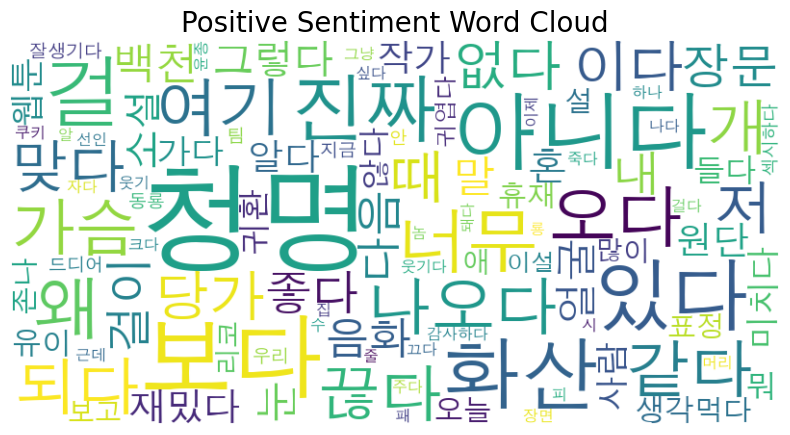

{'청명': 1118, '보다': 631, '아니다': 540, '화산': 457, '있다': 456, '걸': 451, '진짜': 395, '너무': 362, '왜': 357, '오다': 330, '여기': 305, '같다': 296, '나오다': 295, '되다': 295, '끊다': 289, '가슴': 288, '개': 280, '저': 256, '맞다': 244, '때': 243, '이다': 236, '당가': 231, '없다': 231, '장문': 224, '걸이': 222, '내': 221, '좋다': 215, '다음': 209, '말': 185, '음화': 182, '백천': 181, '얼굴': 180, '눈': 174, '그렇다': 173, '소설': 170, '혼': 165, '재밌다': 164, '원단': 163, '알다': 153, '작가': 153, '웹툰': 147, '사람': 142, '미치다': 140, '가다': 140, '귀환': 140, '들다': 139, '뭐': 139, '않다': 138, '생각': 138, '유이': 138, '먹다': 132, '휴재': 130, '오늘': 126, '존나': 125, '표정': 125, '애': 124, '설': 124, '많이': 123, '보고': 122, '리코': 122, '이설': 121, '귀엽다': 117, '잘생기다': 116, '우리': 115, '드디어': 115, '팀': 115, '섹시하다': 113, '안': 110, '지금': 108, '동룡': 108, '감사하다': 104, '집': 103, '크다': 99, '자다': 99, '이제': 97, '수': 97, '그냥': 96, '머리': 96, '근데': 94, '윤종': 93, '하나': 92, '끄다': 91, '알': 90, '시': 87, '패': 87, '나다': 86, '웃기다': 86, '줄': 85, '싶다': 83, '쿠키': 80, '돼다': 79, '장면': 78, '룡': 77, '선인

In [178]:
# 긍정 및 부정 감정에 대한 Word Cloud 생성
create_wordcloud(positive_word_freq, 'Positive Sentiment Word Cloud')
print(positive_word_freq)

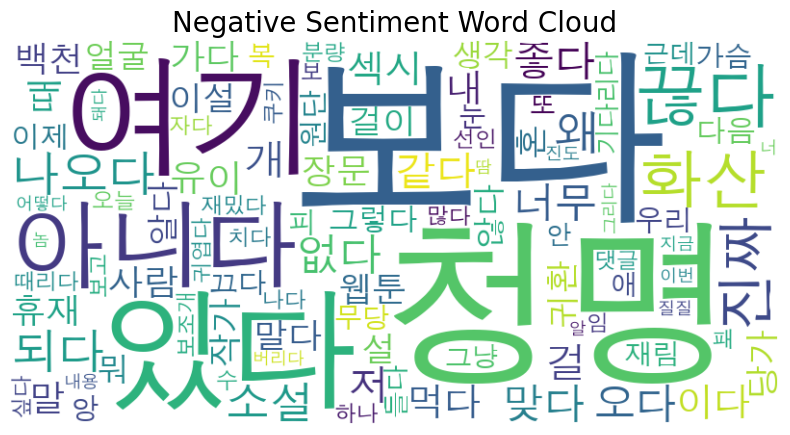

{'보다': 563, '청명': 500, '있다': 233, '여기': 226, '아니다': 222, '끊다': 213, '화산': 170, '진짜': 142, '나오다': 141, '왜': 140, '되다': 132, '소설': 117, '없다': 114, '너무': 111, '개': 107, '맞다': 106, '오다': 106, '좋다': 106, '저': 100, '같다': 99, '걸': 98, '섹시': 87, '이다': 84, '때': 83, '먹다': 81, '내': 80, '유이': 76, '말': 75, '사람': 71, '귀환': 66, '백천': 66, '설': 66, '휴재': 65, '가다': 65, '장문': 64, '혼': 64, '말다': 63, '작가': 62, '당가': 62, '웹툰': 61, '걸이': 61, '이설': 61, '얼굴': 59, '않다': 59, '뭐': 59, '알다': 59, '생각': 58, '그렇다': 58, '다음': 57, '원단': 57, '이제': 55, '끄다': 54, '우리': 54, '애': 52, '복': 52, '눈': 51, '피': 51, '앙': 51, '가슴': 50, '재림': 50, '무당': 50, '그냥': 47, '들다': 47, '안': 45, '근데': 44, '또': 44, '기다리다': 44, '때리다': 44, '치다': 43, '패': 43, '오늘': 42, '보고': 42, '재밌다': 41, '나다': 40, '보조개': 40, '선인': 40, '많다': 39, '분량': 39, '댓글': 39, '자다': 38, '쿠키': 38, '임': 37, '귀엽다': 36, '수': 35, '하나': 35, '보': 35, '싶다': 35, '어떻다': 35, '질질': 34, '버리다': 34, '그리다': 34, '돼다': 34, '진도': 34, '놈': 34, '너': 34, '이번': 34, '땀': 34, '지금': 33, '내용': 33, '알

In [179]:
# 긍정 및 부정 감정에 대한 Word Cloud 생성
create_wordcloud(negative_word_freq, 'Negative Sentiment Word Cloud')
print(negative_word_freq)